In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import uniform_filter1d
from scipy.optimize import curve_fit
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import data_utils.data_analysis as data_analysis
import models.tools as models_tools
import models.rf as rf

In [2]:
def conv_energy(x):
    energy=0.000002*x**2 - 0.0003 * x + .1265
    return energy

In [3]:
#remove the average signal
def rmv_mean(df_camera,lastpoints):
    x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
    #get the coeficients for each shhot
    coef=df_camera.apply(lambda row: np.polyfit(x[-lastpoints:], row[-lastpoints:], 1),axis=1, result_type='expand').to_numpy()
    m=coef[:,0]
    b=coef[:,1]

    #build the aray with the fitting for every shot
    fit=[]
    for i in range(0,len(m)):
        fit.append(m[i]*x+b[i])
    df_fitting=pd.DataFrame(fit)

    df_adjusted=df_camera-df_fitting
    return df_adjusted

In [4]:
## Fit a curve to given (x,y) data
def fitting(x,y,p0):
    popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
    return popt

#define the curve to fit
def func(t,c0, c1,c2): 
    #return c0*np.log(c1)+c2*t
    #return c0*x**2+c1*x+c2
    return c0*np.exp(-((t-c1)**2)/(2*c2*c2))

#Look for max location using the fitting function (around the maximum value)
#Returns the 'pixel' location of the maximum
def find_max(e_dist):
    try:
        #x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #redefine a shorter range around the max
        e_zoom=e_dist[int(0.5*np.argmax(e_dist)):int(1.5*np.argmax(e_dist))]
        x_zoom=np.linspace(int(0.5*np.argmax(e_dist)),int(1.5*np.argmax(e_dist))-1,len(e_zoom))
        p0=[np.max(e_dist),500,1]#initial guess
        popt=fitting(x_zoom,e_zoom,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]

In [5]:
#input a single shot (and the max location) and returns the position of the cut-off
def get_cutoff(df_camera_shot,maxpos):
    #The function look for the first zero value after the max value
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

#input a single shot and returns the position of the cut-off
#This will be SLOWER because we need to recalculate the max
def get_cutoff_2(df_camera_shot):
    #The function look for the first zero value after the max value
    #1:Look for the max value
    maxpos=find_max(df_camera_shot)
    #print(maxpos,len(df_camera_shot))
    #2)
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

In [6]:
def integr(e_dist):
    x=np.linspace(0,len(e_dist)-1,len(e_dist))
    #calculate the start(first positive) and end of integration(cut off)
    max_pos=find_max(e_dist)
    cutoff_pos=get_cutoff(e_dist,max_pos)  #end position
    start_pos=0
    for i in range(0,len(e_dist)):
        if (e_dist[i]>0):
            #print(i,e_dist[i])
            start_pos=i
            break
    e_dist_short=e_dist[start_pos:cutoff_pos]
    x_short=x[start_pos:cutoff_pos]
    
    #x=np.linspace(0,len(e_dist_short)-1,len(e_dist_short))
    x_ene=conv_energy(x_short)
    #return integrate.simpson(e_dist, x=x_ene)
    return integrate.trapezoid(e_dist_short, x=x_ene)

In [7]:
#returns the camera metrics dataframe after doind an avergae over the shots with same Dazzler parameters
def shot_average(df_input,df_metrics):
    emax_list=[]
    ecut_list=[]
    integ_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    emax_mean=[]
    emax_std=[]
    ecut_mean=[]
    ecut_std=[]
    integ_mean=[]
    integ_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            emax_list.append(df_metrics['Max E'].iloc[index])
            ecut_list.append(df_metrics['Cutoff E'].iloc[index])
            integ_list.append(df_metrics['Integr'].iloc[index])
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                emax_list.append(df_metrics['Max E'].iloc[index])
                ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                integ_list.append(df_metrics['Integr'].iloc[index])
            else:
                #do the calc
                emax_mean.append(np.mean(emax_list))
                emax_std.append(np.std(emax_list))
                ecut_mean.append(np.mean(ecut_list))
                ecut_std.append(np.std(ecut_list))
                integ_mean.append(np.mean(integ_list))
                integ_std.append(np.std(integ_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                #start the new batch
                emax_list=[df_metrics['Max E'].iloc[index]]
                ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                integ_list=[df_metrics['Integr'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_metrics_avg=pd.DataFrame()
    df_metrics_avg['order2']=o2_list
    df_metrics_avg['order3']=o3_list
    df_metrics_avg['order4']=o4_list
    df_metrics_avg['Emax mean']=emax_mean
    df_metrics_avg['Emax std']=emax_std
    df_metrics_avg['Ecut mean']=ecut_mean
    df_metrics_avg['Ecut std']=ecut_std
    df_metrics_avg['Integr mean']=integ_mean
    df_metrics_avg['Integr std']=integ_std
    return df_metrics_avg

## Read camera data

In [8]:
filename_camera='datasets/galadriel_dataset_24_06_28_phys.h5'

In [9]:
df_input_camera=pd.read_hdf(filename_camera,'df_input')
df_camera=pd.read_hdf(filename_camera,'df_camera')


#get the arrays and print them
print('Input DF')
print(df_input_camera)

print('----')
print('Camera 1D')
print(df_camera)

Input DF
      shot number   order2   order3     order4
0          152354  34900.0 -17000.0 -4600000.0
1          152355  34900.0 -17000.0 -4600000.0
2          152356  34900.0 -17000.0 -4600000.0
3          152357  34900.0 -17000.0 -4600000.0
4          152358  34900.0 -17000.0 -4600000.0
...           ...      ...      ...        ...
3068       155422  35400.0  28000.0 -3700000.0
3069       155423  35400.0  28000.0 -3700000.0
3070       155424  35400.0  28000.0 -3700000.0
3071       155425  35400.0  28000.0 -3700000.0
3072       155426  35400.0  28000.0 -3700000.0

[3073 rows x 4 columns]
----
Camera 1D
         0        1        2        3        4        5        6        7     \
0      7.8350   7.7175   7.6275   8.0125   7.1775   8.2700   7.6475   8.2300   
1      4.9625   5.3575   5.0575   5.3150   4.9625   5.2625   5.0600   5.4075   
2      5.7550   5.4150   5.5075   5.9650   5.5225   6.1475   5.5550   5.5625   
3      6.6550   6.9925   6.4275   7.1600   6.5275   7.0425   7.0100

In [10]:
#smooth the whole camera dataframe
df_camera_smooth=df_camera.apply(uniform_filter1d,axis=1,size=10,result_type='broadcast')
#then remove the mean signal
lastpoints=500
df_camera_adjusted=rmv_mean(df_camera_smooth,lastpoints)

### construct the dataframe with the camera metrics

In [11]:
df_metrics=pd.DataFrame()
df_metrics['Max E']=df_camera_adjusted.apply(find_max,axis=1)
#convert to Energy
df_metrics['Max E']=df_metrics['Max E'].apply(conv_energy)

#calculate hte cutoff energy
df_metrics['Cutoff E']=df_camera_adjusted.apply(get_cutoff_2,axis=1)
#convert to Energy
df_metrics['Cutoff E']=df_metrics['Cutoff E'].apply(conv_energy)

#calculate the integral
df_metrics['Integr']=df_camera_adjusted.apply(integr,axis=1)

/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in t

/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in t

/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in t

/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max


/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max


/tmp/ipykernel_8563/3460704502.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)


Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in the find max
Error in t

In [12]:
#drop shots with wrong peak E calculations
df_metrics_reduced=df_metrics[df_metrics['Max E']>0.2]

good_shots_list=df_metrics_reduced.index.values
#print(good_shots_list)
df_input_reduced=df_input_camera.iloc[good_shots_list]

#reset the index
df_metrics_reduced.reset_index(inplace=True,drop=True)
df_input_reduced.reset_index(inplace=True,drop=True)

In [13]:
#Average the shots with same input coeeficients
df_metrics_avg=shot_average(df_input_reduced,df_metrics_reduced)

## Take the good performers

In [14]:
df_good_perf=df_metrics_avg[df_metrics_avg['Emax mean']>1.0]

In [15]:
df_good_perf

,order2,order3,order4,Emax mean,Emax std,Ecut mean,Ecut std,Integr mean,Integr std
21,34900.0,-2000.0,-4300000.0,1.081205,0.141051,4.276910,0.382071,32.204429,14.065074
25,34900.0,1000.0,-4300000.0,1.098386,0.163489,4.148748,0.440734,28.680978,15.650752
41,34900.0,13000.0,-4300000.0,1.031129,0.132249,4.227221,0.240281,31.231846,11.173527
50,34900.0,19000.0,-4000000.0,1.047090,0.111963,4.305563,0.261284,36.292607,13.835520
85,35000.0,-2000.0,-4300000.0,1.064328,0.092812,4.427341,0.150257,33.246528,8.569053
88,35000.0,1000.0,-4600000.0,1.076389,0.162014,4.378186,0.282910,34.095690,10.880582
89,35000.0,1000.0,-4300000.0,1.029848,0.115794,4.233211,0.223240,31.278057,9.684375
101,35000.0,10000.0,-4300000.0,1.023897,0.203038,4.126918,0.302684,28.097090,10.394959
160,35100.0,7000.0,-4600000.0,1.141396,0.212498,4.169943,0.177504,30.799281,8.557611
164,35100.0,10000.0,-4600000.0,1.038927,0.191940,4.156435,0.177846,25.730326,7.551722


# Train the forward model

In [16]:
filename='datasets/galadriel_dataset_24_06_28.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
       shot number  order2  order3     order4
0           136497   34900  -17000 -4600000.0
1           136498   34900  -17000 -4600000.0
2           136499   34900  -17000 -4600000.0
3           136500   34900  -17000 -4500000.0
4           136501   34900  -17000 -4500000.0
...            ...     ...     ...        ...
15503       152002   35400   29000 -3800000.0
15504       152003   35400   29000 -3800000.0
15505       152004   35400   29000 -3700000.0
15506       152005   35400   29000 -3700000.0
15507       152006   35400   29000 -3700000.0

[15508 rows x 4 columns]
----
Time values
0    -115.458450
1    -104.962227
2     -94.466005
3     -83.969782
4     -73.473559
5     -62.977336
6     -52.481114
7     -41.984891
8     -31.488668
9     -20.992445
10    -10.496223
11      0.000000
12     10.496223
13     20.992445
14     31.488668
15     41.984891
16     52.481114
17     62.977336
18     73.473559
19     83.969782
20     94.466005
21    104.962227
Name: 0, dtype: float6

In [17]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

#train forward model with Random forest
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

In [18]:
#test_input=df_good_perf[['order2','order3','order4']].iloc[2].tolist()
good_perf_input=df_good_perf[['order2','order3','order4']]
print(good_perf_input)

      order2   order3     order4
21   34900.0  -2000.0 -4300000.0
25   34900.0   1000.0 -4300000.0
41   34900.0  13000.0 -4300000.0
50   34900.0  19000.0 -4000000.0
85   35000.0  -2000.0 -4300000.0
88   35000.0   1000.0 -4600000.0
89   35000.0   1000.0 -4300000.0
101  35000.0  10000.0 -4300000.0
160  35100.0   7000.0 -4600000.0
164  35100.0  10000.0 -4600000.0
212  35200.0  -2000.0 -4600000.0
216  35200.0   1000.0 -4600000.0
220  35200.0   4000.0 -4600000.0
221  35200.0   4000.0 -4300000.0
224  35200.0   7000.0 -4600000.0
228  35200.0  10000.0 -4600000.0
233  35200.0  13000.0 -4300000.0
236  35200.0  16000.0 -4600000.0
237  35200.0  16000.0 -4300000.0
280  35300.0   1000.0 -4600000.0
284  35300.0   4000.0 -4600000.0
296  35300.0  13000.0 -4600000.0
301  35300.0  16000.0 -4300000.0
337  35400.0   1000.0 -4600000.0
339  35400.0   4000.0 -4600000.0


In [19]:
y_predict=rf.make_rf_prediction(forward_model_rf,good_perf_input)

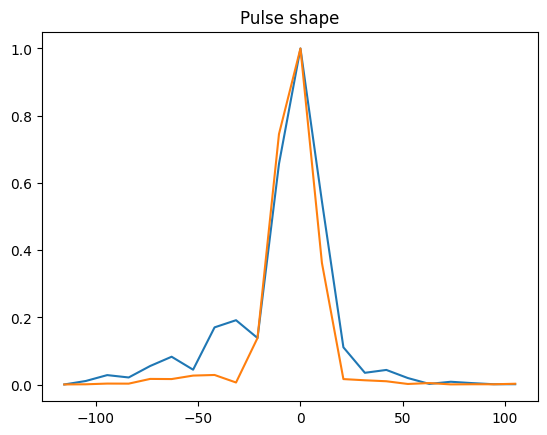

In [20]:
#plt.plot(df_time_val,y_predict[7])
plt.plot(df_time_val,y_predict[8])
#plt.plot(df_time_val,y_predict[9])
#plt.plot(df_time_val,y_predict[10])
#plt.plot(df_time_val,y_predict[11])
plt.plot(df_time_val,y_predict[0])
plt.title('Pulse shape')
plt.show()

Text(0.2, 0.3, '$\\beta^4=$-4300000.0')

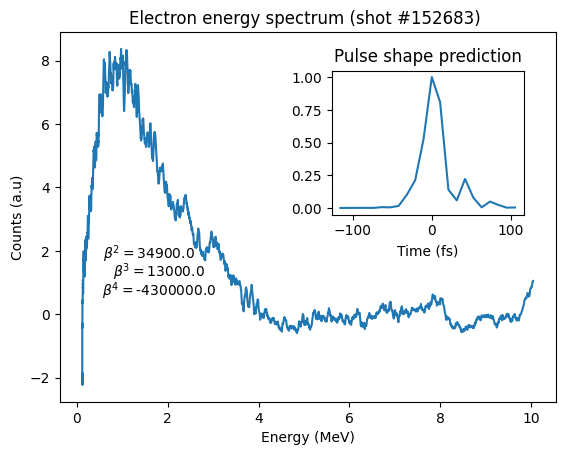

In [21]:
#plot the E distribution and its puls prediction
good_shot_index=2
input_param=good_perf_input.iloc[good_shot_index]
#look for the shots with the same Dazller parameters
df_input_shot=df_input_camera[df_input_camera['order2']==input_param['order2']]
df_input_shot=df_input_shot[df_input_shot['order3']==input_param['order3']]
df_input_shot=df_input_shot[df_input_shot['order4']==input_param['order4']]

shot_index=df_input_shot.index.values[0] #get the first shot with those param
shot_num=df_input_shot['shot number'].iloc[0]
order2=input_param['order2']
order3=input_param['order3']
order4=input_param['order4']

e_dist_adj=df_camera_adjusted.loc[shot_index]
x=np.linspace(0,len(e_dist_adj)-1,len(e_dist_adj))
x_ene=conv_energy(x)

fig, ax = plt.subplots()

left, bottom, width, height = [0.55, 0.5, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(df_time_val,y_predict[good_shot_index])
ax2.set_xlabel('Time (fs)')
ax2.set_title('Pulse shape prediction')

ax.plot(x_ene,e_dist_adj)
#plt.xlim(0,8)
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Counts (a.u)')
ax.set_title('Electron energy spectrum (shot #'+str(shot_num)+') ')

ax.text(0.18, 0.4, r'$\beta^2=$'+str(order2), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.2, 0.35, r'$\beta^3=$'+str(order3), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.2, 0.3, r'$\beta^4=$'+str(order4), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# PCA

### Train the PCA

In [22]:
pca_comp=5
#normalize the pulse dataset
scaler=StandardScaler()
df_time_norm = scaler.fit_transform(y_train) #only on the training set
#Train the pca space using the _morm
pca=PCA(n_components=pca_comp).fit(df_time_norm)
#convert to pca space
df_time_pca=pca.transform(df_time_norm)

### Transform prediction to PCA space

In [23]:
#normalize
y_predict_norm=scaler.fit_transform(y_predict)
#transfrom to PCA spcae
y_predict_pca=pca.transform(y_predict_norm)

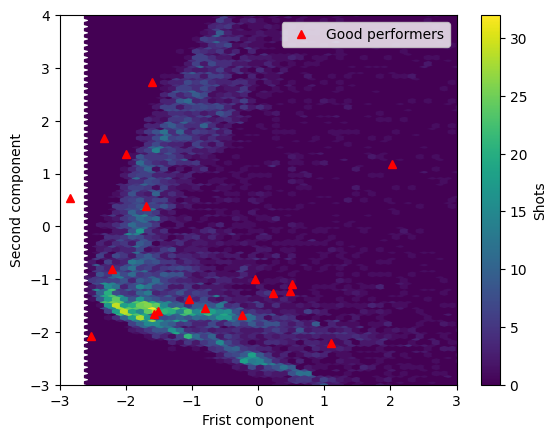

In [66]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_time_pca[:,0], df_time_pca[:,1],gridsize=300)#,cmap='jet')
plt.plot(y_predict_pca[:,0],y_predict_pca[:,1],marker='^',color='red',linestyle='None',label='Good performers')
ax.set_xlabel('Frist component')
ax.set_ylabel('Second component')
ax.set_xlim(-3,3)
ax.set_ylim(-3,4)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Shots')
plt.legend()

In [63]:
#plt.plot(df_time_pca[:,0],df_time_pca[:,1],marker='d',linestyle='None',label='All shots')
#plt.plot(y_predict_pca[:,0],y_predict_pca[:,1],marker='s',linestyle='None',label='Good performers')
#plt.xlabel('First component')
#plt.ylabel('Second component')
#plt.legend()

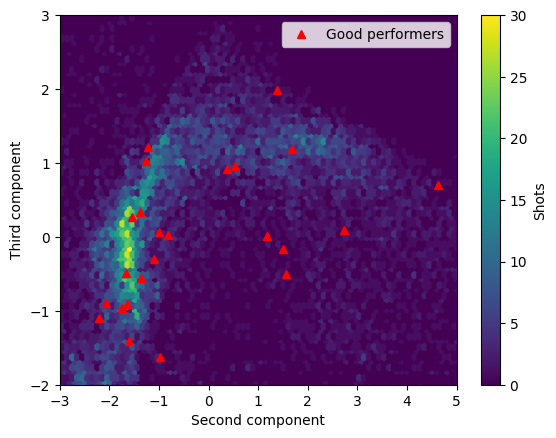

In [67]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_time_pca[:,1], df_time_pca[:,2],gridsize=200)#,cmap='jet')
plt.plot(y_predict_pca[:,1],y_predict_pca[:,2],marker='^',color='red',linestyle='None',label='Good performers')
ax.set_xlabel('Second component')
ax.set_ylabel('Third component')
ax.set_xlim(-3,5)
ax.set_ylim(-2,3)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Shots')
plt.legend()

In [64]:
#plt.plot(df_time_pca[:,1],df_time_pca[:,2],marker='d',linestyle='None',label='All shots')
#plt.plot(y_predict_pca[:,1],y_predict_pca[:,2],marker='s',linestyle='None',label='Good performers')
#plt.xlabel('Second component')
#plt.ylabel('Third component')
#plt.legend()

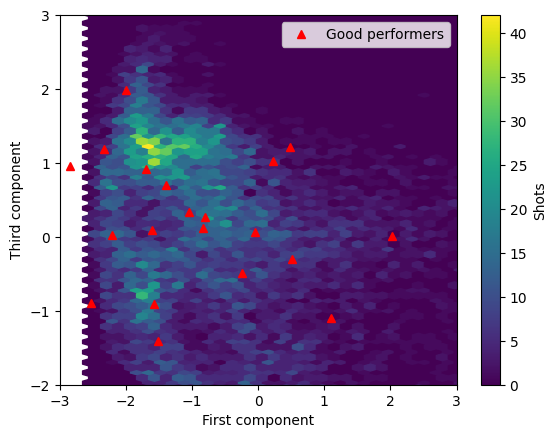

In [68]:
fig, ax = plt.subplots()
h1=ax.hexbin(df_time_pca[:,0], df_time_pca[:,2],gridsize=200)#,cmap='jet')
plt.plot(y_predict_pca[:,0],y_predict_pca[:,2],marker='^',color='red',linestyle='None',label='Good performers')
ax.set_xlabel('First component')
ax.set_ylabel('Third component')
ax.set_xlim(-3,3)
ax.set_ylim(-2,3)
cbar =fig.colorbar(h1, ax=ax)
cbar.set_label('Shots')
plt.legend()

In [65]:
#plt.plot(df_time_pca[:,0],df_time_pca[:,2],marker='d',linestyle='None')
#plt.plot(y_predict_pca[:,0],y_predict_pca[:,2],marker='s',linestyle='None')
#plt.xlabel('First component')
#plt.ylabel('Third component')

/tmp/ipykernel_8563/2304641190.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(y_predict_pca[:,0],y_predict_pca[:,1], y_predict_pca[:,2],c='r',cmap='jet')


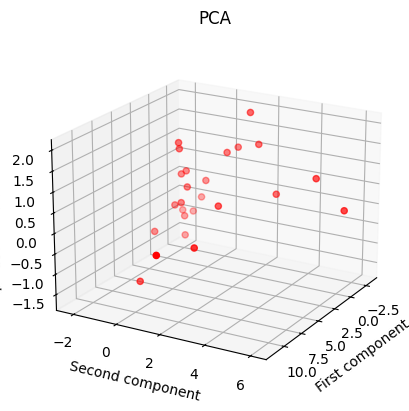

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.scatter(df_time_pca[:,0],df_time_pca[:,1], df_time_pca[:,2],c='c',cmap='jet')
ax.scatter(y_predict_pca[:,0],y_predict_pca[:,1], y_predict_pca[:,2],c='r',cmap='jet')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')
#zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
#ax.set_zticks(np.log10(zticks))
#print(df_error)
#ax.set_zscale('log')
ax.view_init(elev=20., azim=30)
plt.title('PCA')
plt.show()